# Importing and Installing necessary dependencies

In [2]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.corpus import stopwords
import random
from skmultilearn.model_selection import IterativeStratification
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [42]:
import zipfile

In [4]:
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopword removal
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Preprocessing Method

In [5]:
def clean_text(text):
    text = text.lower()  # lower-case all characters
    text = re.sub(r"[^ a-zA-Z]", ' ', text)  # only keeps alphabetic characters
    text = "".join([i for i in text if i not in string.punctuation])  # remove punctuation
    words = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')   # remove stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i)>2])
    return text

# Loading Datasets

We load the training and validation datasets.

In [45]:
extraction_directory = './'
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:

  zip_ref.extractall('data')

print("Success")

Success


In [46]:
df = pd.read_csv('./data/CW2-training-dataset.csv')

In [47]:
df_val = pd.read_csv('./data/CW2-validation-dataset.csv')

# Preparing Training Data

We will use 2 classifiers: model_small for classifying rare classes and model_big for classifying regular classes. Accordingly we divide the dataset into 2 parts: the first part has all the rows corresponding to rare classes along with a small subset of dataset where the rare classes are 0. We will train model_small on this dataset.

The other dataset will be used to train model_big.


In [8]:
df.head()

,ID,title,plot_synopsis,comedy,cult,flashback,historical,murder,revenge,romantic,scifi,violence
0,8f5203de-b2f8-4c0c-b0c1-835ba92422e9,Si wang ta,"After a recent amount of challenges, Billy Lo ...",0,0,0,0,1,1,0,0,1
1,6416fe15-6f8a-41d4-8a78-3e8f120781c7,Shattered Vengeance,"In the crime-ridden city of Tremont, renowned ...",0,0,0,0,1,1,1,0,1
2,4979fe9a-0518-41cc-b85f-f364c91053ca,L'esorciccio,Lankester Merrin is a veteran Catholic priest ...,0,1,0,0,0,0,0,0,0
3,b672850b-a1d9-44ed-9cff-025ee8b61e6f,Serendipity Through Seasons,"""Serendipity Through Seasons"" is a heartwarmin...",0,0,0,0,0,0,1,0,0
4,b4d8e8cc-a53e-48f8-be6a-6432b928a56d,The Liability,"Young and naive 19-year-old slacker, Adam (Jac...",0,0,1,0,0,0,0,0,0


## Visualizing the data

In [9]:
bar_plot = pd.DataFrame()
bar_plot['cat'] = df.columns[3:]
bar_plot['count'] = df.iloc[:,3:].sum().values
bar_plot.sort_values(['count'], inplace=True, ascending=False)
bar_plot.reset_index(inplace=True, drop=True)
bar_plot.head(9)

,cat,count
0,murder,4019
1,violence,3064
2,romantic,2006
3,flashback,1994
4,cult,1801
5,revenge,1657
6,comedy,1262
7,scifi,204
8,historical,186


<ipython-input-10-0ff3cba57f5d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='cat',
<ipython-input-10-0ff3cba57f5d>:10: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(x='cat',


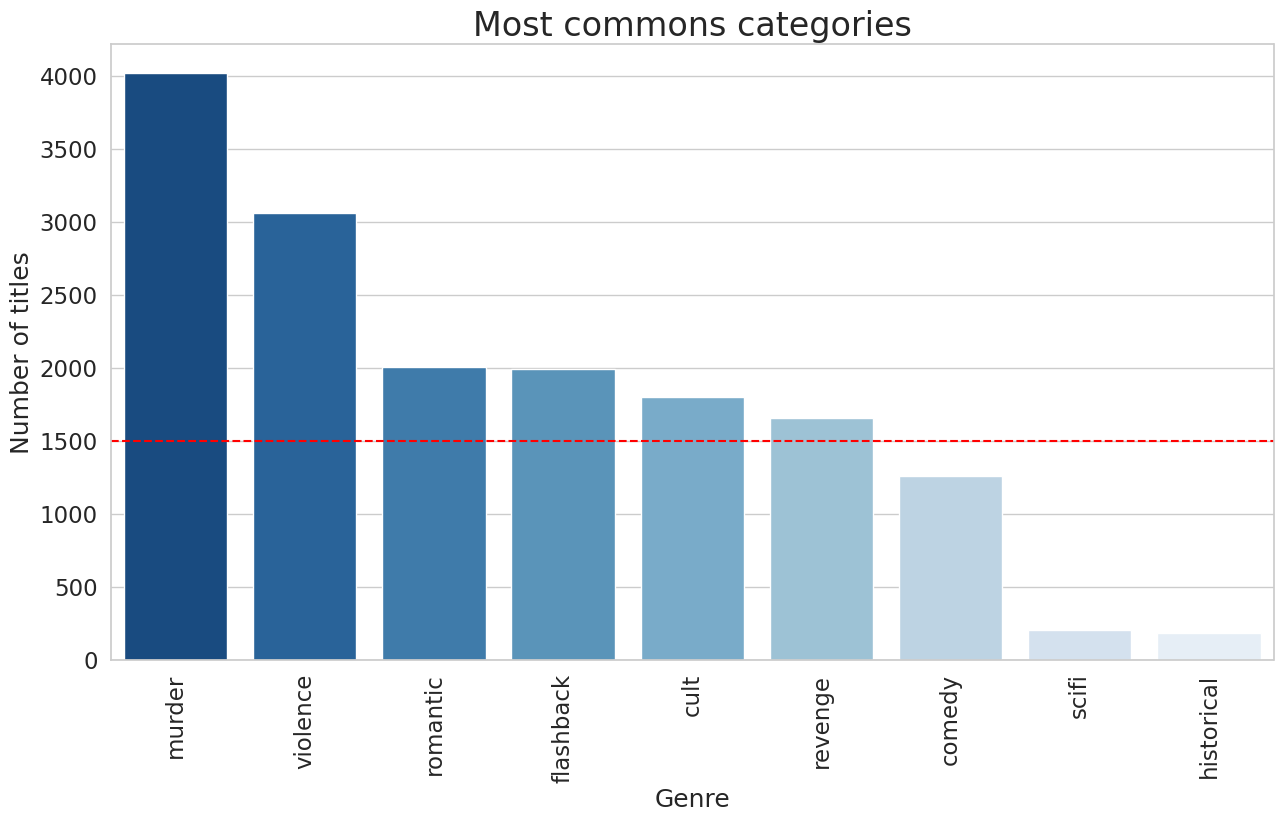

In [10]:
threshold = 1500
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')


pal = sns.color_palette("Blues_r", len(bar_plot))
rank = bar_plot['count'].argsort().argsort()

sns.barplot(x='cat',
    y='count',
    data=bar_plot,
    palette=np.array(pal[::-1])[rank])

plt.axhline(threshold, ls='--', c='red')
plt.title("Most commons categories", fontsize=24)
plt.ylabel('Number of titles', fontsize=18)
plt.xlabel('Genre', fontsize=18)
plt.xticks(rotation='vertical')

plt.show()

### We clean all plot synopsis

In [11]:
df['plot_synopsis'] = df['plot_synopsis'].apply(clean_text)

In [12]:
df.head(3)

,ID,title,plot_synopsis,comedy,cult,flashback,historical,murder,revenge,romantic,scifi,violence
0,8f5203de-b2f8-4c0c-b0c1-835ba92422e9,Si wang ta,recent amount challenges billy bruce lee frien...,0,0,0,0,1,1,0,0,1
1,6416fe15-6f8a-41d4-8a78-3e8f120781c7,Shattered Vengeance,crime ridden city tremont renowned investigati...,0,0,0,0,1,1,1,0,1
2,4979fe9a-0518-41cc-b85f-f364c91053ca,L'esorciccio,lankester merrin veteran catholic priest exorc...,0,1,0,0,0,0,0,0,0


### We extract the labels

In [13]:
labels = df.columns[3:]
print(labels)

Index(['comedy', 'cult', 'flashback', 'historical', 'murder', 'revenge',
       'romantic', 'scifi', 'violence'],
      dtype='object')


In [14]:
y_train = df[labels].values

In [15]:
y_train.shape

(8257, 9)

### Extract rare classes

In [16]:
filtered_df = df[(df['scifi'] == 1) | (df['historical'] == 1)]

### Extract data where both are 0

In [17]:
filtered_df_zeros = df[(df['scifi'] == 0) & (df['historical'] == 0)]
sampled_df = filtered_df_zeros.sample(n=200, random_state=42)

In [18]:
# Combine both subsets
combined_df = pd.concat([filtered_df, sampled_df])

# Reset index for the combined DataFrame (optional)
combined_df.reset_index(drop=True, inplace=True)

### Extracting dataset for model_big

In [19]:
df_remaining = df.merge(combined_df, how='outer', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])


In [20]:
combined_df = combined_df[['plot_synopsis', 'historical', 'scifi']]

In [21]:
combined_df.head()

,plot_synopsis,historical,scifi
0,century sexual intercourse reproduction prohib...,0,1
1,national boundaries broken two giant super sta...,0,1
2,robotics technology advanced point cybernetics...,0,1
3,set near future huge megacorporations control ...,0,1
4,london england popular writer herbert george w...,0,1


In [22]:
combined_df.shape

(590, 3)

### Prepare dataset for model_big

In [23]:
df_remaining.shape

(7667, 12)

In [24]:
df_remaining = df_remaining.drop(columns=['ID', 'title', 'historical', 'scifi'])

In [25]:
df_remaining.head()

,plot_synopsis,comedy,cult,flashback,murder,revenge,romantic,violence
0,angel heart ominous street midnight dark figur...,0,1,1,1,0,0,1
1,movie begins see fletcher brendan fraser seems...,0,0,0,0,0,1,0
2,ahmad ibn fadlan court poet caliph baghdad amo...,0,1,0,1,0,1,1
3,spy extraordinaire derek flint james coburn ag...,0,0,0,1,0,0,1
4,set mid nineteenth century narrator identifies...,0,0,0,0,0,1,0


### Prepare vector inputs for Model

In [27]:
max_vocab_size = 20000
tokenizer = Tokenizer(num_words = max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['plot_synopsis'])

In [28]:
sequences_big_train = tokenizer.texts_to_sequences(df_remaining['plot_synopsis'])
max_sequence_length = 150
X_big_train = pad_sequences(sequences_big_train, maxlen = max_sequence_length)

In [29]:
sequences_small_train = tokenizer.texts_to_sequences(combined_df['plot_synopsis'])
max_sequence_length = 150
X_small_train = pad_sequences(sequences_small_train, maxlen = max_sequence_length)

In [30]:
print(X_big_train.shape)
print(X_small_train.shape)

(7667, 150)
(590, 150)


In [31]:
y_big_train = df_remaining[['comedy', 'cult', 'flashback', 'murder', 'revenge', 'romantic', 'violence']]

In [32]:
y_big_train = y_big_train.values

In [33]:
y_small_train = combined_df[['scifi', 'historical']]

In [34]:
y_small_train = y_small_train.values

In [35]:
print(y_big_train.shape)
print(y_small_train.shape)

(7667, 7)
(590, 2)


## Training

We use stratified split on training data. Then we use K-fold cross validation to pick the best model. We do this for both classifiers.

### Model_big training

In [50]:
n_splits = 5
skf = IterativeStratification(n_splits=n_splits, order=1)

# Store histories for analysis
histories = []

# Define hyperparameter ranges for random selection
learning_rates = [0.001]
lstm_units = [32, 64, 128]
dropout_rates = [0.5]
batch_sizes = [32]

best_model = None
best_accuracy_score = -np.inf
# Multilabel Stratified K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(skf.split(X_big_train, y_big_train)):
    print(f"Processing Fold {fold + 1}/{n_splits}")

    # Split data into train and validation sets
    X_train, X_val = X_big_train[train_index], X_big_train[val_index]
    y_train, y_val = y_big_train[train_index], y_big_train[val_index]

    # Randomly select hyperparameters for this fold
    learning_rate = random.choice(learning_rates)
    lstm_unit = random.choice(lstm_units)
    dropout_rate = random.choice(dropout_rates)
    batch_size = random.choice(batch_sizes)

    print(f"Using Hyperparameters: learning_rate={learning_rate}, lstm_units={lstm_unit}, dropout_rate={dropout_rate}, batch_size={batch_size}")

    # Define model with selected hyperparameters
    model_big = Sequential()
    model_big.add(Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length))
    model_big.add(Bidirectional(LSTM(units=lstm_unit, return_sequences=False)))
    model_big.add(Dense(64, activation='relu'))
    model_big.add(Dropout(dropout_rate))
    model_big.add(Dense(7, activation='sigmoid'))  # Multi-label classification
    model_big.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model_big.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=10,  # Add class weights
        verbose=1
    )

    # Save history for analysis
    histories.append(history)
    val_accuracy = np.mean(history.history['val_accuracy'][-1])

    if val_accuracy > best_accuracy_score:
        best_accuracy_score = val_accuracy
        best_model = model_big  # Save the model with the best performance

# After the loop, `best_model` contains the model with the best validation F1 score
print("Best Model found with F1 score:", best_accuracy_score)


Processing Fold 1/2
Using Hyperparameters: learning_rate=0.001, lstm_units=128, dropout_rate=0.5, batch_size=32
Epoch 1/10
121/121 [==============================] - 66s 517ms/step - loss: 0.5899 - accuracy: 0.2019 - val_loss: 0.5666 - val_accuracy: 0.2669
Epoch 2/10
121/121 [==============================] - 62s 509ms/step - loss: 0.5400 - accuracy: 0.2627 - val_loss: 0.5415 - val_accuracy: 0.3020
Epoch 3/10
121/121 [==============================] - 61s 509ms/step - loss: 0.4528 - accuracy: 0.3636 - val_loss: 0.5448 - val_accuracy: 0.2879
Epoch 4/10
121/121 [==============================] - 61s 509ms/step - loss: 0.3311 - accuracy: 0.5035 - val_loss: 0.6073 - val_accuracy: 0.2703
Epoch 5/10
121/121 [==============================] - 61s 507ms/step - loss: 0.2255 - accuracy: 0.6104 - val_loss: 0.7257 - val_accuracy: 0.2501
Epoch 6/10
121/121 [==============================] - 61s 509ms/step - loss: 0.1694 - accuracy: 0.6468 - val_loss: 0.7935 - val_accuracy: 0.2661
Epoch 7/10
121/121

In [51]:
best_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 150, 128)          2560000   
                                                                 
 bidirectional_6 (Bidirecti  (None, 256)               263168    
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 7)                 455       
                                                                 
Total params: 2840071 (10.83 MB)
Trainable params: 2840071 (10.83 MB)
Non-trainable params: 0 (0.00 Byte)
______________

### Model_small training

In [79]:
n_splits = 10
skf = IterativeStratification(n_splits=n_splits, order=1)

# Store histories for analysis
histories = []

# Define hyperparameter ranges for random selection
learning_rates = [0.001]
lstm_units = [32, 64]
dropout_rates = [0.5, 0.7]
batch_sizes = [4, 8, 16, 32]

best_model_small = None
best_accuracy_score = -np.inf
# Multilabel Stratified K-Fold Cross-Validation
for fold, (train_index, val_index) in enumerate(skf.split(X_small_train, y_small_train)):
    print(f"Processing Fold {fold + 1}/{n_splits}")

    # Split data into train and validation sets
    X_train, X_val = X_small_train[train_index], X_small_train[val_index]
    y_train, y_val = y_small_train[train_index], y_small_train[val_index]

    # Randomly select hyperparameters for this fold
    learning_rate = random.choice(learning_rates)
    lstm_unit = random.choice(lstm_units)
    dropout_rate = random.choice(dropout_rates)
    batch_size = random.choice(batch_sizes)

    print(f"Using Hyperparameters: learning_rate={learning_rate}, lstm_units={lstm_unit}, dropout_rate={dropout_rate}, batch_size={batch_size}")

    model_small = Sequential()
    model_small.add(Embedding(input_dim=max_vocab_size, output_dim=64, input_length=max_sequence_length))
    model_small.add(Bidirectional(LSTM(units=lstm_unit, return_sequences=False)))
    model_small.add(Dense(32, activation = 'relu'))
    model_small.add(Dropout(dropout_rate))
    model_small.add(Dense(2, activation='sigmoid'))
    model_small.compile(optimizer=Adam(learning_rate = learning_rate),
                  loss = 'binary_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    history = model_small.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=3,
        verbose=1
    )

    # Save history for analysis
    histories.append(history)
    val_accuracy = np.mean(history.history['val_accuracy'][-1])

    if val_accuracy > best_accuracy_score:
        best_accuracy_score = val_accuracy
        best_model_small = model_small  # Save the model with the best performance

# After the loop, `best_model` contains the model with the best validation F1 score
print("Best Model found with Accuracy score:", best_accuracy_score)


Processing Fold 1/10
Using Hyperparameters: learning_rate=0.001, lstm_units=64, dropout_rate=0.7, batch_size=16
Epoch 1/3
34/34 [==============================] - 8s 134ms/step - loss: 0.6670 - accuracy: 0.5461 - val_loss: 0.6345 - val_accuracy: 0.6780
Epoch 2/3
34/34 [==============================] - 3s 102ms/step - loss: 0.6320 - accuracy: 0.5895 - val_loss: 0.6275 - val_accuracy: 0.6780
Epoch 3/3
34/34 [==============================] - 3s 100ms/step - loss: 0.5676 - accuracy: 0.6610 - val_loss: 0.6193 - val_accuracy: 0.7119
Processing Fold 2/10
Using Hyperparameters: learning_rate=0.001, lstm_units=32, dropout_rate=0.7, batch_size=8
Epoch 1/3
67/67 [==============================] - 12s 99ms/step - loss: 0.6648 - accuracy: 0.5122 - val_loss: 0.6413 - val_accuracy: 0.3220
Epoch 2/3
67/67 [==============================] - 6s 89ms/step - loss: 0.6155 - accuracy: 0.5085 - val_loss: 0.6337 - val_accuracy: 0.6610
Epoch 3/3
67/67 [==============================] - 6s 88ms/step - loss: 0

In [67]:
best_model_small.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 150, 64)           1280000   
                                                                 
 bidirectional_19 (Bidirect  (None, 128)               66048     
 ional)                                                          
                                                                 
 dense_38 (Dense)            (None, 32)                4128      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_39 (Dense)            (None, 2)                 66        
                                                                 
Total params: 1350242 (5.15 MB)
Trainable params: 1350242 (5.15 MB)
Non-trainable params: 0 (0.00 Byte)
_______________

# Preparing Valid Set

In [80]:
df_val['plot_synopsis'] = df_val['plot_synopsis'].apply(clean_text)

In [81]:
df_val.head()

,ID,title,plot_synopsis,comedy,cult,flashback,historical,murder,revenge,romantic,scifi,violence
0,cf32cb00-172d-40f2-a3c1-936e8a0d89d7,Shattered Hearts,enchanting city verona italy renowned painter ...,0,0,0,0,1,0,1,0,0
1,df7e125e-2d59-40e4-a126-9397e3a0ef21,Point Blank,walker works friend mal reese steal large amou...,0,1,1,0,1,1,0,0,1
2,49bc73f3-9179-41cd-9774-905c7a3ac91b,Le charme discret de la bourgeoisie,film consists several thematically linked scen...,1,0,1,0,0,0,0,0,0
3,0ed4822b-87af-44bc-a677-7f7abfdaccf3,A Gentleman's Dignity,gentleman dignity careers love lives urban pro...,0,0,0,0,0,0,1,0,0
4,0b1b0fa4-43bc-41ba-9598-b3401894b96d,Carmen: A Hip Hopera,carmen brown beyonc seductive aspiring actress...,0,0,0,0,1,0,0,0,0


In [82]:
val_sequences = tokenizer.texts_to_sequences(df_val['plot_synopsis'])
X_val = pad_sequences(val_sequences, maxlen = max_sequence_length)
y_val = df_val[labels].values

In [83]:
print(X_val.shape)
print(y_val.shape)

(1188, 150)
(1188, 9)


## Evaluating in Validation Set

In [72]:
y_val_pred_big = best_model.predict(X_val)
y_val_pred_big_binary = (y_val_pred_big > 0.5).astype(int)

38/38 [==============================] - 4s 93ms/step


In [73]:
y_val_pred_big_binary.shape

(1188, 7)

In [84]:
y_val_pred_small = best_model_small.predict(X_val)
y_val_pred_small_binary = (y_val_pred_small > 0.5).astype(int)

38/38 [==============================] - 1s 18ms/step


In [85]:
y_val_pred_small_binary.shape

(1188, 2)

In [86]:
big_part_1 = y_val_pred_big_binary[:, :3]  # First 3 columns
big_part_2 = y_val_pred_big_binary[:, 3:-1]  # Columns 3 to second-last
big_part_3 = y_val_pred_big_binary[:, -1:]
small_column_1 = y_val_pred_small_binary[:, 0:1]  # First column
small_column_2 = y_val_pred_small_binary[:, 1:2]
y_val_pred_binary = np.hstack((big_part_1, small_column_1, big_part_2, small_column_2, big_part_3))

In [87]:
output_df = df_val[['ID']].copy()
output_df[labels] = y_val_pred_binary

In [88]:
output_df.head(4)

,ID,comedy,cult,flashback,historical,murder,revenge,romantic,scifi,violence
0,cf32cb00-172d-40f2-a3c1-936e8a0d89d7,0,0,0,0,0,0,1,0,0
1,df7e125e-2d59-40e4-a126-9397e3a0ef21,0,0,0,0,1,0,0,1,0
2,49bc73f3-9179-41cd-9774-905c7a3ac91b,0,0,1,0,1,0,0,0,0
3,0ed4822b-87af-44bc-a677-7f7abfdaccf3,0,0,0,0,0,0,0,1,0


In [89]:
output_df.to_csv('./data/12345678_task1_results.csv', header = False, index=False)

# Experimenting On Test Dataset

In [200]:
df_test = pd.read_csv('./data/CW2-test-dataset.csv', header = None)

In [201]:
df_test.head()

,0,1,2
0,9484ac61-0e30-4799-9998-6f74f4cbb204,Standoff,"A young girl, Bird with her aunt's boyfriend w..."
1,55942d28-b6a2-4662-ab55-a66783a86a56,On Our Merry Way,Oliver Pease (Burgess Meredith) has deceived h...
2,b71ed317-04cd-42f5-a380-d21dfea2bd36,My Life Without Me,Ann (Sarah Polley) is a hard-working 23-year-o...
3,5689b1b2-88cd-4c22-9114-0850ba539280,Ben & Arthur,Ben (Jamie Brett Gabel) and Arthur (Sam Mraovi...
4,a0d9062e-f539-4043-bc9e-2a2ed589477b,Where the Sidewalk Ends,New York City 16th Precinct Police Detective D...


In [202]:
df_test.columns = ['ID', 'title', 'plot_synopsis']

In [203]:
df_test.head()

,ID,title,plot_synopsis
0,9484ac61-0e30-4799-9998-6f74f4cbb204,Standoff,"A young girl, Bird with her aunt's boyfriend w..."
1,55942d28-b6a2-4662-ab55-a66783a86a56,On Our Merry Way,Oliver Pease (Burgess Meredith) has deceived h...
2,b71ed317-04cd-42f5-a380-d21dfea2bd36,My Life Without Me,Ann (Sarah Polley) is a hard-working 23-year-o...
3,5689b1b2-88cd-4c22-9114-0850ba539280,Ben & Arthur,Ben (Jamie Brett Gabel) and Arthur (Sam Mraovi...
4,a0d9062e-f539-4043-bc9e-2a2ed589477b,Where the Sidewalk Ends,New York City 16th Precinct Police Detective D...


In [204]:
df_test['plot_synopsis'] = df_test['plot_synopsis'].apply(clean_text)

In [205]:
test_sequences = tokenizer.texts_to_sequences(df_test['plot_synopsis'])
X_test = pad_sequences(test_sequences, maxlen = max_sequence_length)

In [206]:
y_test_pred_big = model_big.predict(X_test)
y_test_pred_big_binary = (y_test_pred_big > 0.5).astype(int)

38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step


In [207]:
y_test_pred_small = model_small.predict(X_test)
y_test_pred_small_binary = (y_test_pred_small > 0.5).astype(int)

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step


In [208]:
big_part_1_test = y_test_pred_big_binary[:, :3]  # First 3 columns
big_part_2_test = y_test_pred_big_binary[:, 3:-1]  # Columns 3 to second-last
big_part_3_test = y_test_pred_big_binary[:, -1:]
small_column_1_test = y_test_pred_small_binary[:, 0:1]  # First column
small_column_2_test = y_test_pred_small_binary[:, 1:2]
y_test_pred_binary = np.hstack((big_part_1_test, small_column_1_test, big_part_2_test, small_column_2_test, big_part_3_test))

In [209]:
test_pred_df = df_test[['ID']].copy()
test_pred_df[labels] = y_test_pred_binary

In [210]:
test_pred_df.head(4)

,ID,comedy,cult,flashback,historical,murder,revenge,romantic,scifi,violence
0,9484ac61-0e30-4799-9998-6f74f4cbb204,0,1,0,1,0,0,0,0,0
1,55942d28-b6a2-4662-ab55-a66783a86a56,0,0,0,0,0,0,1,0,0
2,b71ed317-04cd-42f5-a380-d21dfea2bd36,0,0,0,0,0,0,1,0,0
3,5689b1b2-88cd-4c22-9114-0850ba539280,1,0,1,0,1,0,0,0,1


In [211]:
test_pred_df.to_csv('./data/11098060_task1_results.csv', header = False, index=False)